In [ ]:
from google.colab import drive

In [ ]:
#mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2

#functions to read the video clips
class Videoto3D:

    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def video3d(self, filename, color=False, skip=True):
        
        cap = cv2.VideoCapture(filename)

        nframe = cap.get(cv2.CAP_PROP_FRAME_COUNT)

        if skip:
            frames = [x * nframe / self.depth for x in range(self.depth)]
        else:
            frames = [x for x in range(self.depth)]
        
        framearray = []

        for i in range(self.depth):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
            ret, frame = cap.read()
            try:
              frame = cv2.resize(frame, (self.height, self.width))
            except:
              print("break here")
              break
        
            if color:
                framearray.append(frame)
            else:
                framearray.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        cap.release()
        
        return np.array(framearray)

In [ ]:
import argparse
import os

import matplotlib
matplotlib.use('AGG')

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import cifar10
from keras.layers import (Activation, Conv2D, Dense, Dropout, Flatten,
                          MaxPool2D, Input, ZeroPadding2D,TimeDistributed,LSTM)
import keras
from keras.layers import ELU, PReLU, LeakyReLU, Input
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split

from tqdm import tqdm

from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from keras.backend import set_session

#function to load videos and labels from the given path to directory
def loaddata(video_dir, vid3d, nclass, color=False, skip=True):
    
    files = os.listdir(video_dir)  
    X = []
    labels = []
    pbar = tqdm(total=len(files))
    
    for filename in files:

        pbar.update(1)

        name = os.path.join(video_dir, filename)
        for v_files in os.listdir(name):
        
            v_file_path = os.path.join(name, v_files)
            
            X.append(vid3d.video3d(v_file_path, color=color, skip=skip))

            labels.append(int(name[-1]))

    pbar.close()

    if color:
        return np.array(X), labels
    else:
        return np.array(X), labels

In [ ]:
#parameters for dataset
depth = 16
img_rows, img_cols, frames = 112, 112, depth
channel = 3 
batch = 16
epoch = 60
videos = '/content/drive/MyDrive/Actual_BDD/Clipped_Train1_16_10'
color = True
skip = False
nclass = 8

vid3d = Videoto3D(img_rows, img_cols, frames)
nb_classes = 8
#return data in x and labels in y
x, y = loaddata(videos, vid3d, nclass, color, skip)

print(x.shape)

#reshape x and convert labels to categorical for the model
X = x.reshape((x.shape[0], frames, img_cols, img_rows, channel))
Y = np_utils.to_categorical(y,num_classes=nb_classes)

X = X.astype('float32')
    
print('\nX_shape:{}\nY_shape:{}'.format(X.shape, Y.shape))

100%|██████████| 8/8 [01:04<00:00,  8.01s/it]

(80, 16, 112, 112, 3)

X_shape:(80, 16, 112, 112, 3)
Y_shape:(80, 8)


In [ ]:
#define the model

model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'), input_shape=(16, 112, 112, 3)))
model.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
model.add(TimeDistributed(MaxPool2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPool2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPool2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPool2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(512, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(MaxPool2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(8, activation='softmax'))
model.summary()

#define optimizer and compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer,loss=categorical_crossentropy,metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 16, 56, 56, 32)   4736      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 54, 54, 32)   9248      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 27, 27, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 27, 27, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 16, 27, 27, 64)  

## **Comments**:

When the model is run once without cross validation the training plots look like below:

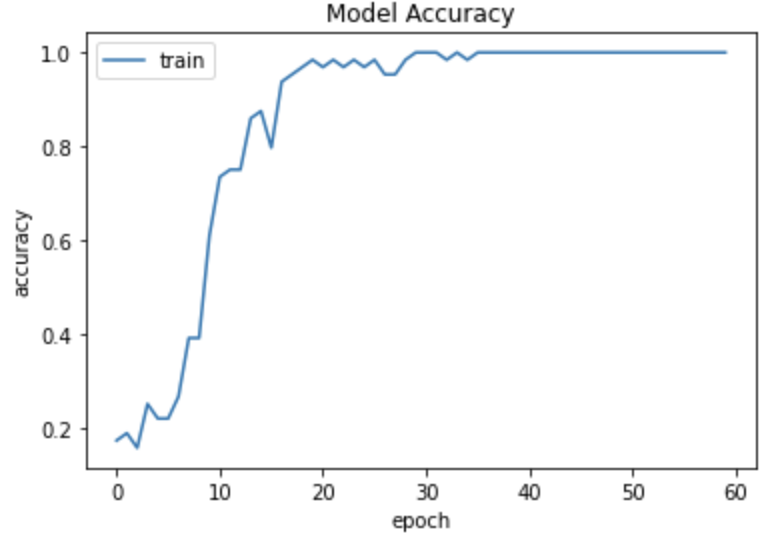

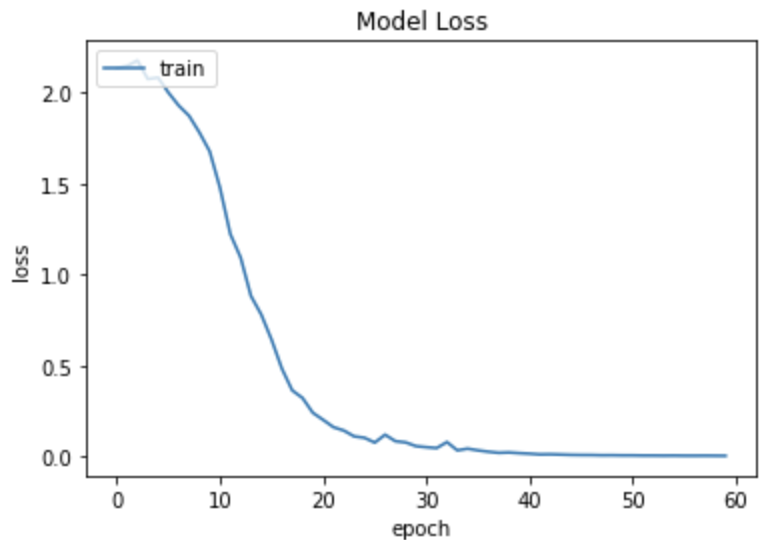

When 10 fold cross validation (even stratified) is implemented the training plots immediately reach 100% accuracy and low loss, even for the first fold. When the folds are reduced (8 as below), the first fold has a similar plot but starting accuracy is still pretty high and loss is low. This might be because of the very limited dataset (but why are all plots immediately reaching 100 only when cross fold is applied, not for when the model is run once?). 

0it [00:00, ?it/s]

kfold 1
Epoch 1/30
5/5 [==============================] - 2s 368ms/step - loss: 0.1907 - accuracy: 0.9143
Epoch 2/30
5/5 [==============================] - 1s 100ms/step - loss: 0.5451 - accuracy: 0.7571
Epoch 3/30
5/5 [==============================] - 1s 103ms/step - loss: 0.4308 - accuracy: 0.9143
Epoch 4/30
5/5 [==============================] - 1s 100ms/step - loss: 0.2890 - accuracy: 0.9286
Epoch 5/30
5/5 [==============================] - 1s 101ms/step - loss: 0.1906 - accuracy: 0.9857
Epoch 6/30
5/5 [==============================] - 1s 103ms/step - loss: 0.1564 - accuracy: 0.9429
Epoch 7/30
5/5 [==============================] - 1s 102ms/step - loss: 0.0789 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 109ms/step - loss: 0.0629 - accuracy: 0.9714
Epoch 9/30
5/5 [==============================] - 1s 112ms/step - loss: 0.0552 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 109ms/step - loss: 0.0464 - accuracy: 0.9857
Epoch 11/30

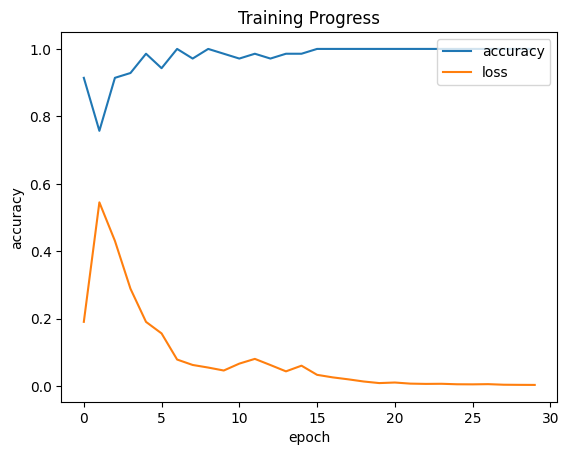

1it [00:19, 19.62s/it]

kfold 2
Epoch 1/30
5/5 [==============================] - 1s 114ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 115ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 111ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 111ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 102ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 101ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 102ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 101ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 9/30
5/5 [==============================] - 1s 102ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 104ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 11/30

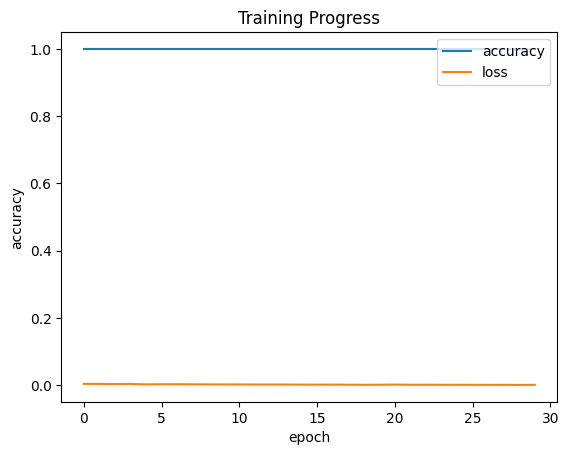

2it [00:36, 18.20s/it]

kfold 3
Epoch 1/30
5/5 [==============================] - 1s 103ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 102ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 102ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 103ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 101ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 101ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 101ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 104ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 9/30
5/5 [==============================] - 1s 104ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 106ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 11/30

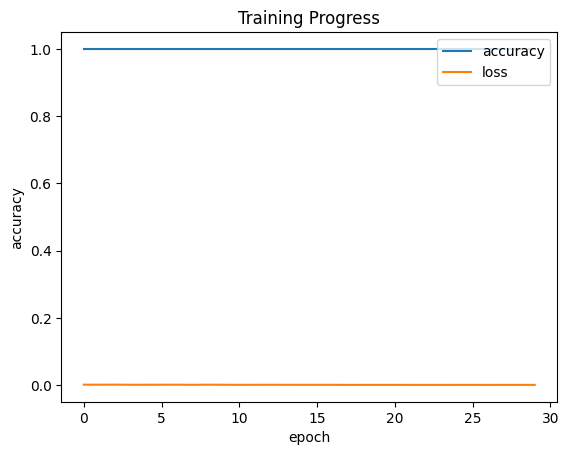

3it [00:58, 19.59s/it]

kfold 4
Epoch 1/30
5/5 [==============================] - 1s 105ms/step - loss: 7.4413e-04 - accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 102ms/step - loss: 6.8288e-04 - accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 104ms/step - loss: 7.4161e-04 - accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 104ms/step - loss: 6.2472e-04 - accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 116ms/step - loss: 7.4229e-04 - accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 115ms/step - loss: 5.7893e-04 - accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 116ms/step - loss: 5.3393e-04 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 113ms/step - loss: 6.5631e-04 - accuracy: 1.0000
Epoch 9/30
5/5 [==============================] - 1s 112ms/step - loss: 6.0478e-04 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 111ms/step - loss: 6

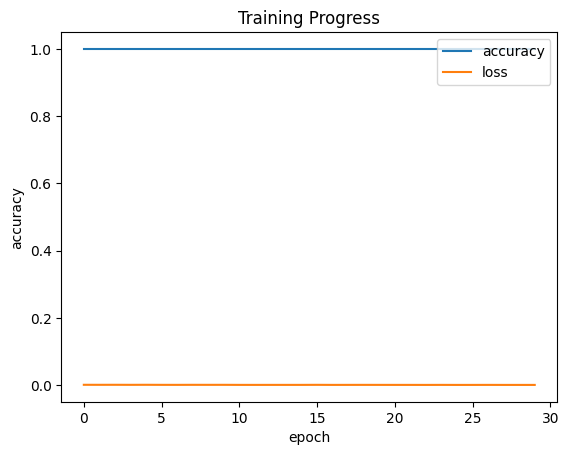

4it [01:19, 20.22s/it]

kfold 5
Epoch 1/30
5/5 [==============================] - 1s 102ms/step - loss: 4.0722e-04 - accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 102ms/step - loss: 3.5568e-04 - accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 104ms/step - loss: 3.5750e-04 - accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 104ms/step - loss: 4.6399e-04 - accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 102ms/step - loss: 4.3506e-04 - accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 103ms/step - loss: 3.1814e-04 - accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 101ms/step - loss: 4.1083e-04 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 102ms/step - loss: 3.5605e-04 - accuracy: 1.0000
Epoch 9/30
5/5 [==============================] - 1s 102ms/step - loss: 3.6027e-04 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 103ms/step - loss: 3

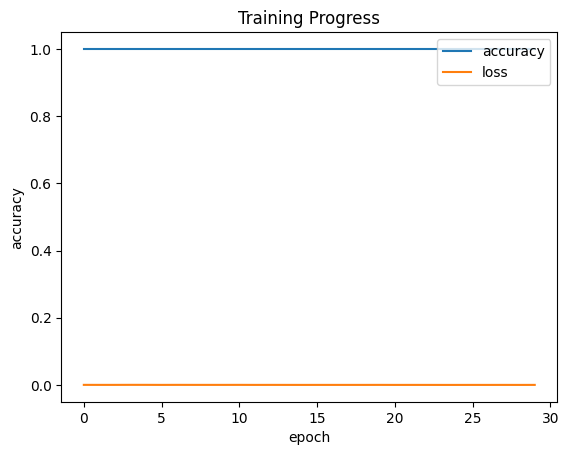

5it [01:36, 19.18s/it]

kfold 6
Epoch 1/30
5/5 [==============================] - 1s 103ms/step - loss: 3.1139e-04 - accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 102ms/step - loss: 2.4883e-04 - accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 102ms/step - loss: 2.5041e-04 - accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 103ms/step - loss: 2.0368e-04 - accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 102ms/step - loss: 1.9321e-04 - accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 101ms/step - loss: 2.9937e-04 - accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 107ms/step - loss: 2.5899e-04 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 109ms/step - loss: 2.0534e-04 - accuracy: 1.0000
Epoch 9/30
5/5 [==============================] - 1s 108ms/step - loss: 1.9399e-04 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 110ms/step - loss: 2

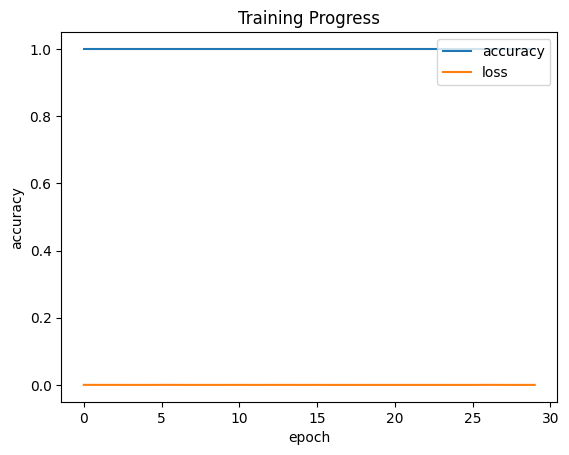

6it [01:53, 18.56s/it]

kfold 7
Epoch 1/30
5/5 [==============================] - 1s 116ms/step - loss: 1.3292e-04 - accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 110ms/step - loss: 1.6914e-04 - accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 112ms/step - loss: 1.7291e-04 - accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 111ms/step - loss: 1.1278e-04 - accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 109ms/step - loss: 1.9784e-04 - accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 113ms/step - loss: 1.4339e-04 - accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 107ms/step - loss: 1.5971e-04 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 101ms/step - loss: 1.6698e-04 - accuracy: 1.0000
Epoch 9/30
5/5 [==============================] - 1s 103ms/step - loss: 1.3114e-04 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 103ms/step - loss: 1

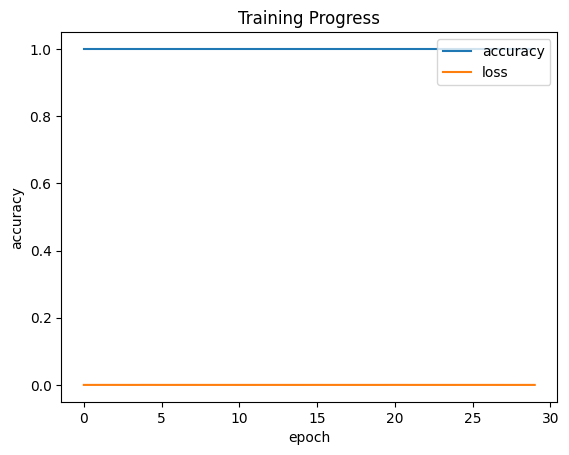

7it [02:15, 19.43s/it]

kfold 8
Epoch 1/30
5/5 [==============================] - 1s 104ms/step - loss: 1.5084e-04 - accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 102ms/step - loss: 1.4151e-04 - accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 103ms/step - loss: 1.5557e-04 - accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 103ms/step - loss: 1.2634e-04 - accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 102ms/step - loss: 1.4356e-04 - accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 103ms/step - loss: 1.4944e-04 - accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 101ms/step - loss: 1.7936e-04 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 102ms/step - loss: 1.3443e-04 - accuracy: 1.0000
Epoch 9/30
5/5 [==============================] - 1s 101ms/step - loss: 1.4966e-04 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 102ms/step - loss: 1

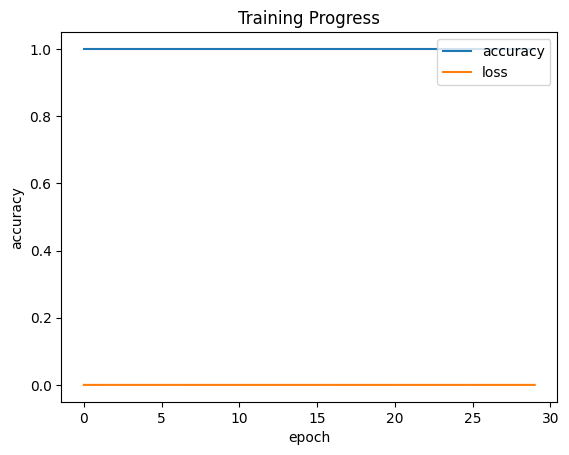

8it [02:32, 19.02s/it]


In [ ]:
from tqdm import tqdm
from sklearn.model_selection import KFold

#perform k-fold cross validation
scores, histories = list(), list()

kfold = KFold(8, shuffle=True, random_state=1)
# enumerate splits
k = 0
for train_ix, test_ix in tqdm(kfold.split(X)):
    print('kfold {}'.format(k+1)) 
    # select rows for train and test
    trainX, trainY, testX, testY = X[train_ix], Y[train_ix], X[test_ix], Y[test_ix]
    # fit model
    history = model.fit(trainX, trainY, batch_size=batch,
                    epochs=30, verbose=1, shuffle=True)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    %matplotlib inline
    plt.plot(history.history['accuracy'])
    plt.title('Training Progress')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.plot(history.history['loss'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy','loss'], loc='upper right')
    plt.show()
    #print('> %.3f',.6% (acc * 100.0))
    # append scores
    scores.append(acc)
    histories.append(history)
    #print('Accuracy: %.3f%% (+/- %.3f)' % (np.mean(scores)*100, np.std(scores)))
    k = k + 1

In [ ]:
print(scores)
#accuracy
print('Cross Validation Accuracy:' , np.array(scores).mean()*100)

[0.8999999761581421, 0.949999988079071]
Cross Validation Accuracy: 92.49999821186066


0it [00:00, ?it/s]

kfold 1
Epoch 1/30
5/5 [==============================] - 1s 106ms/step - loss: 1.6866e-04 - accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 103ms/step - loss: 1.4186e-04 - accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 102ms/step - loss: 1.0508e-04 - accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 102ms/step - loss: 1.0081e-04 - accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 104ms/step - loss: 8.9723e-05 - accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 105ms/step - loss: 8.8594e-05 - accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 115ms/step - loss: 1.1632e-04 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 115ms/step - loss: 7.9056e-05 - accuracy: 1.0000
Epoch 9/30
5/5 [==============================] - 1s 116ms/step - loss: 1.1866e-04 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 112ms/step - loss: 1

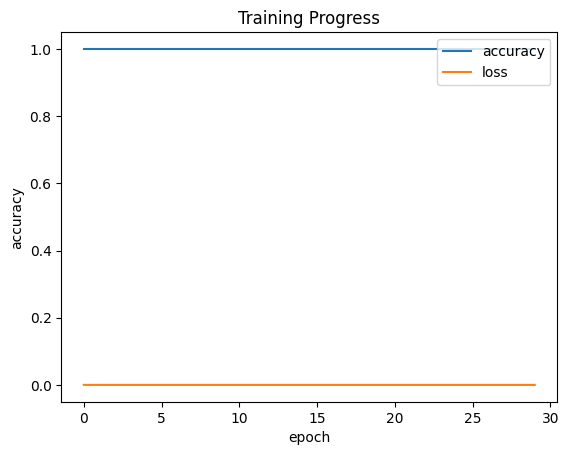

1it [00:16, 16.98s/it]

> 100.000
kfold 2
Epoch 1/30
5/5 [==============================] - 1s 110ms/step - loss: 8.3077e-05 - accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 112ms/step - loss: 8.6724e-05 - accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 111ms/step - loss: 9.7380e-05 - accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 109ms/step - loss: 1.2583e-04 - accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 113ms/step - loss: 6.6149e-05 - accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 112ms/step - loss: 8.5436e-05 - accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 101ms/step - loss: 9.4243e-05 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 102ms/step - loss: 9.3328e-05 - accuracy: 1.0000
Epoch 9/30
5/5 [==============================] - 1s 103ms/step - loss: 8.1023e-05 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 101ms/step

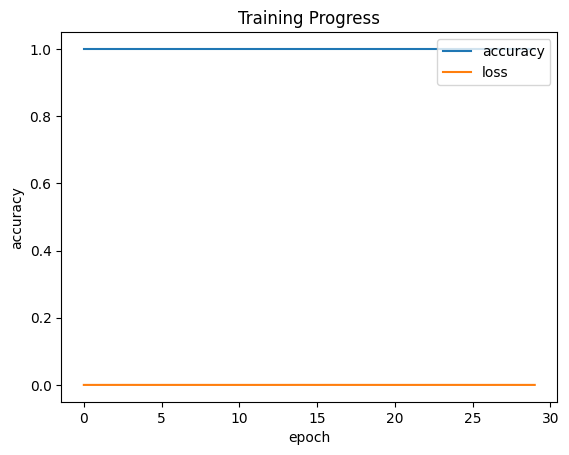

2it [00:38, 19.52s/it]

> 100.000
kfold 3
Epoch 1/30
5/5 [==============================] - 1s 109ms/step - loss: 9.0018e-05 - accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 102ms/step - loss: 8.4317e-05 - accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 102ms/step - loss: 6.3614e-05 - accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 102ms/step - loss: 6.2040e-05 - accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 102ms/step - loss: 8.3602e-05 - accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 101ms/step - loss: 6.9063e-05 - accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 101ms/step - loss: 7.1848e-05 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 101ms/step - loss: 8.0589e-05 - accuracy: 1.0000
Epoch 9/30
5/5 [==============================] - 1s 101ms/step - loss: 6.4962e-05 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 103ms/step

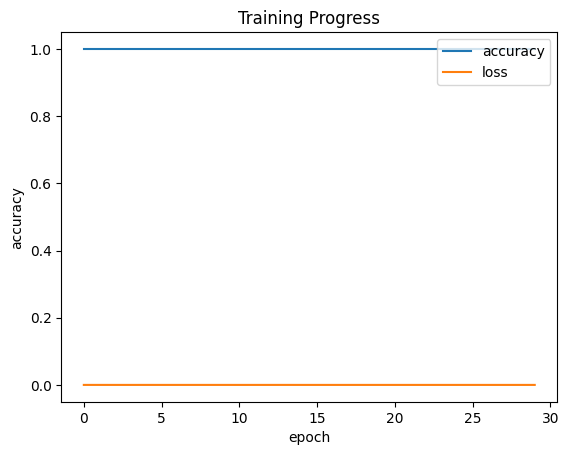

3it [00:59, 20.35s/it]

> 100.000
kfold 4
Epoch 1/30
5/5 [==============================] - 1s 121ms/step - loss: 5.0343e-05 - accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 105ms/step - loss: 6.6298e-05 - accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 102ms/step - loss: 6.4277e-05 - accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 102ms/step - loss: 4.5646e-05 - accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 104ms/step - loss: 7.3018e-05 - accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 102ms/step - loss: 5.2631e-05 - accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 100ms/step - loss: 8.2127e-05 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 101ms/step - loss: 7.4933e-05 - accuracy: 1.0000
Epoch 9/30
5/5 [==============================] - 1s 104ms/step - loss: 4.8201e-05 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 101ms/step

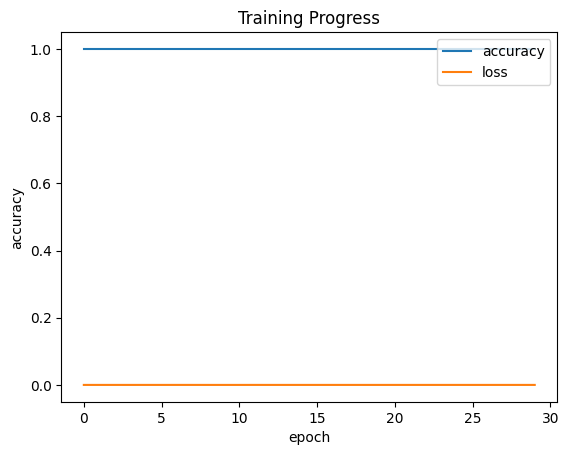

4it [01:16, 19.08s/it]

> 100.000
kfold 5
Epoch 1/30
5/5 [==============================] - 1s 104ms/step - loss: 4.6298e-05 - accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 102ms/step - loss: 7.5375e-05 - accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 101ms/step - loss: 5.6296e-05 - accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 101ms/step - loss: 4.2182e-05 - accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 102ms/step - loss: 4.6205e-05 - accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 103ms/step - loss: 6.1619e-05 - accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 102ms/step - loss: 4.4460e-05 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 102ms/step - loss: 6.5463e-05 - accuracy: 1.0000
Epoch 9/30
5/5 [==============================] - 1s 102ms/step - loss: 5.9900e-05 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 102ms/step

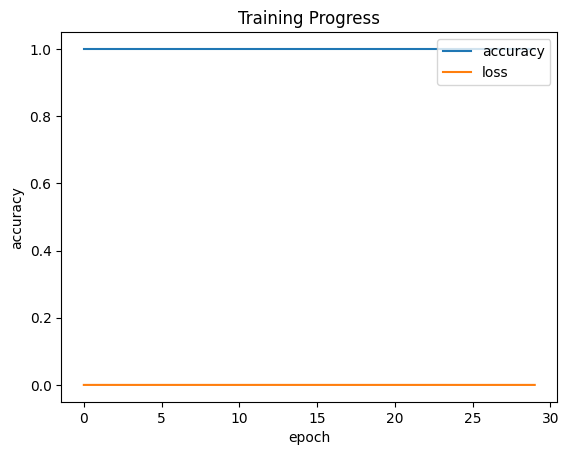

5it [01:37, 19.85s/it]

> 100.000
kfold 6
Epoch 1/30
5/5 [==============================] - 1s 117ms/step - loss: 4.5043e-05 - accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 110ms/step - loss: 5.0980e-05 - accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 111ms/step - loss: 5.0554e-05 - accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 117ms/step - loss: 3.7895e-05 - accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 106ms/step - loss: 4.2621e-05 - accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 107ms/step - loss: 4.8764e-05 - accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 103ms/step - loss: 2.6157e-05 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 107ms/step - loss: 4.6822e-05 - accuracy: 1.0000
Epoch 9/30
5/5 [==============================] - 1s 101ms/step - loss: 5.0825e-05 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 101ms/step

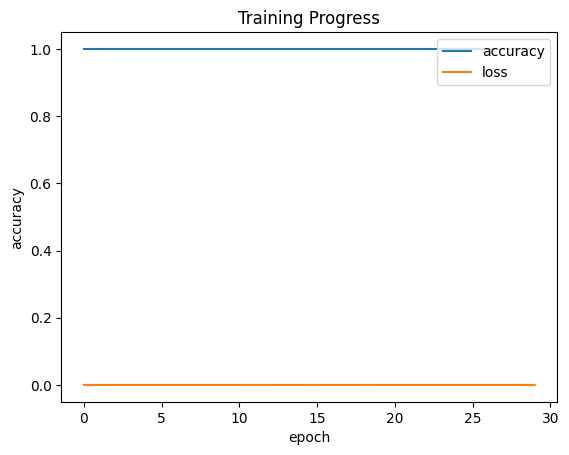

6it [01:59, 20.32s/it]

> 100.000
kfold 7
Epoch 1/30
5/5 [==============================] - 1s 109ms/step - loss: 2.7288e-05 - accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 102ms/step - loss: 5.2972e-05 - accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 104ms/step - loss: 3.6782e-05 - accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 102ms/step - loss: 3.8226e-05 - accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 103ms/step - loss: 4.5959e-05 - accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 103ms/step - loss: 3.2762e-05 - accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 103ms/step - loss: 6.6427e-05 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 103ms/step - loss: 3.1366e-05 - accuracy: 1.0000
Epoch 9/30
5/5 [==============================] - 1s 106ms/step - loss: 4.0762e-05 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 103ms/step

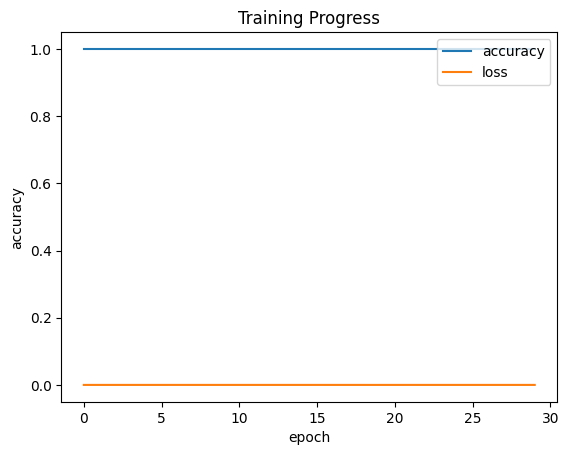

7it [02:20, 20.66s/it]

> 100.000
kfold 8
Epoch 1/30
5/5 [==============================] - 1s 111ms/step - loss: 3.6901e-05 - accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 1s 104ms/step - loss: 3.9365e-05 - accuracy: 1.0000
Epoch 3/30
5/5 [==============================] - 1s 103ms/step - loss: 4.2548e-05 - accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 1s 101ms/step - loss: 4.4897e-05 - accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 1s 102ms/step - loss: 5.0211e-05 - accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 1s 102ms/step - loss: 3.9284e-05 - accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 1s 102ms/step - loss: 4.5679e-05 - accuracy: 1.0000
Epoch 8/30
5/5 [==============================] - 1s 102ms/step - loss: 3.4902e-05 - accuracy: 1.0000
Epoch 9/30
5/5 [==============================] - 1s 106ms/step - loss: 3.3982e-05 - accuracy: 1.0000
Epoch 10/30
5/5 [==============================] - 1s 103ms/step

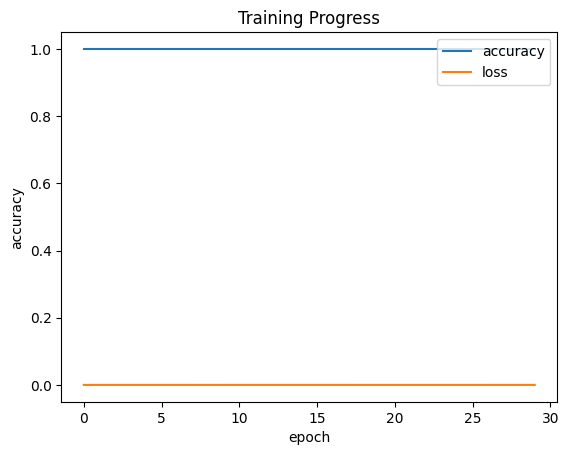

8it [02:41, 20.23s/it]

> 100.000


In [ ]:
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
    
scores, histories = list(), list()
# prepare cross validation
kfold = StratifiedKFold(8, shuffle=True, random_state=1)
# enumerate splits
k = 0
for train_ix, test_ix in tqdm(kfold.split(X,np.argmax(Y, axis=1))):
    print('kfold {}'.format(k+1))
    # select rows for train and test
    trainX, trainY, testX, testY = X[train_ix], Y[train_ix], X[test_ix], Y[test_ix]
    # fit model
    history = model.fit(trainX, trainY, batch_size=batch,
                    epochs=30, verbose=1, shuffle=True)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    %matplotlib inline
    plt.plot(history.history['accuracy'])
    plt.title('Training Progress')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.plot(history.history['loss'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy','loss'], loc='upper right')
    plt.show()
    print('> %.3f' % (acc * 100.0))
    # append scores
    scores.append(acc)
    histories.append(history)
        
    k = k + 1

In [ ]:
#accuracy
print('Cross Validation Accuracy:' , np.array(scores).mean()*100)

Cross Validation Accuracy: 100.0
